# 1. 모델의 개요

### 1.1   문제해결 사항 
* 시도별 공용 충전기 설치 현황(2018년.08) 기준으로 전기자동차 충전소가 서울시와 제주도에 집중되어 있는 것을 알 수 있습니다.

* 전남지역 전기차 충전소 설치 현황(20년 4월 기준)을 살펴보면 전남지역의 대도시에 전기차 충전소가 편중되어 있는 것을 확인할 수 있었고, 이에 따라 광양시는 전기자동차 보급 확대 지원에 따른 여러 정책을 시행하고 있습니다.

* 따라서 AiDL팀은 광양시 정책에 따른 전기 자동차 충전기 추가 설치 최적화 입지를 선정하기 위해서 다음과 같은 계획 수립으로 프로젝트를 진행하여 나갔습니다.


### 1.2 문제 접근 방법
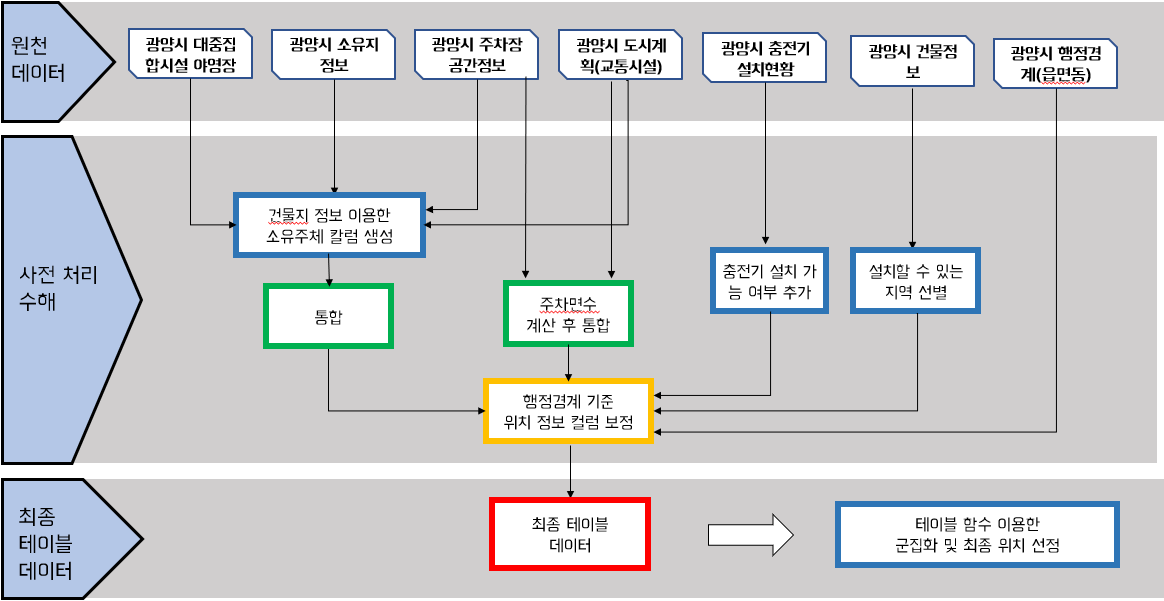



# 2. 분석 내용 및 절차

### 분석 흐름도
2.1 각 데이터 전처리  
2.2 학습테이블 만들기 위한 함수 생성  
2.3 매핑  
2.4 K-Means clustering를 이용한 군집화 & 최종 위치 선정

## 2.1 각 데이터 전처리

제공된 데이터 중 전기차 충전기를 설치할만한 장소라고 생각한 장소들을 직접 선정하여 하나의 테이블로 합친다

In [ ]:
import pathlib
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
import math
import warnings
warnings.filterwarnings(action='ignore')
import folium

In [ ]:
%cd E:\yujin\INHA\data

E:\yujin\INHA\data


In [ ]:
owner_land = gpd.read_file('14.광양시_소유지정보.geojson')
gyboundary = gpd.read_file('20.광양시_행정경계(읍면동).geojson')

chargingStation_raw = pd.read_csv('01.광양시_충전기설치현황.csv')
parkingLot_raw = pd.read_csv('02.광양시_주차장_공간정보.csv')
campsite_raw = pd.read_csv('05.광양시_대중집합시설_야영장.csv')
buildinfo = gpd.read_file("15.광양시_건물정보.geojson")
CulPys_raw = gpd.read_file('25.광양시_도시계획(공공문화체육시설).geojson')
traf_parkingLot_raw = gpd.read_file('26.광양시_도시계획(교통시설).geojson')

### 2.1.1 <05.광양시_대중집합시설_야영장.csv>

1) lon, lat가지고 geometry컬럼 만들기  
2) '14.광양시_소유지정보.geojson'데이터를 바탕으로 야영지 면적을 구하기 (컬럼명 : DGM_AR)  
3) cateogory컬럼 추가  
4) 컬럼명 변경 (소유주체(공공/민간) --> 소유주체)  
5) 주차면수 컬럼 추가 --> 주차장법 시행령: 부설주차장의 설치대상 시설물 종류 및 설치기준에 따라 계산

![image.png](attachment:image.png)

In [ ]:
campsite_raw['geometry'] = campsite_raw.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
owner_list= np.array([owner_land.토지면적[j]  for i in range(len(campsite_raw)) for j in range(len(owner_land)) if campsite_raw.geometry[i].within(owner_land.geometry[j])==True ])
campsite_raw['DGM_AR']=owner_list
campsite_raw['category'] = '야영장'
campsite_raw.rename(columns={"소유주체(공공/민간)":"소유주체"}, inplace=True)
campsite_raw['주차면수'] = (campsite_raw['DGM_AR']/300).astype(int)
campsite_raw

In [ ]:
campsite_raw.to_csv('광양시_대중집합시설_야영장_전처리.csv', index=False, encoding='cp949')

### 2.1.2 <02.광양시_주차장_공간정보.csv>

1) lon, lat가지고 geometry만들기  
2) 컬럼명 변경 (면적 --> DGM_AR)  
3) cateogory 컬럼 추가  
4) 소유지 컬럼 추가  

In [ ]:
parkingLot_raw['geometry'] = parkingLot_raw.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
parkingLot_raw.rename(columns={"면적":"DGM_AR"}, inplace=True)
parkingLot_raw['category'] = '주차장'
parkingLot_owner_list= np.array([owner_land.소유구분명[j] for i in range(len(parkingLot_raw.geometry)) for j in range(len(owner_land.geometry)) if parkingLot_raw.geometry[i].within(owner_land.geometry[j])==True])
parkingLot_raw['소유주체'] = parkingLot_owner_list
parkingLot_raw

In [ ]:
parkingLot_raw.to_csv('광양시_주차장_공간정보_전처리.csv', index=False, encoding='cp949')

### 2.1.3 <26.광양시_도시계획(교통시설).geojson>

1) '주차'관련된 데이터만 추출  
2) 면적이 0인 곳은 제외  
3) geometry를 이용해 lon, lat컬럼을 만들고, geometry의 Multipoligon형태를 Point로 변경   
4) category 컬럼 추가  
5) 소유자 컬럼 추가  
6) 주차면수계산

In [ ]:
#'주차'관련된 데이터만 추출  
traf_parkingLot_raw=traf_parkingLot_raw[traf_parkingLot_raw['DGM_NM'].str.contains('주차')]

#면적이 0인 곳은 제외
drop_index = traf_parkingLot_raw[traf_parkingLot_raw['DGM_AR']==0].index
traf_parkingLot_raw = traf_parkingLot_raw.drop(drop_index)

#geometry를 이용해 lon, lat컬럼을 만들고, geometry의 Multipoligon형태를 Point로 변경
traf_parkingLot_raw['lon']=traf_parkingLot_raw['geometry'].centroid.x  #multipoligon형태여서 중심값 추출
traf_parkingLot_raw['lat']=traf_parkingLot_raw['geometry'].centroid.y
traf_parkingLot_raw['geometry'] = traf_parkingLot_raw.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)

#category컬럼 추가
traf_parkingLot_raw['category'] = '주차장'

traf_parkingLot_raw.reset_index(drop=True,inplace=True)

#소유자 컬럼 추가
traf_parkingLot_raw['소유주체'] = np.nan
for i in range(len(traf_parkingLot_raw)):
    for j in range(len(owner_land)):
        if traf_parkingLot_raw.geometry[i].within(owner_land.geometry[j]) == True:
            traf_parkingLot_raw['소유주체'][i]=owner_land.소유구분명[j]

traf_parkingLot_raw

In [ ]:
traf_parkingLot_raw.to_csv('광양시_도시계획(교통시설)_전처리(주차면수계산 전).csv', index=False, encoding='cp949')

"광양시_도시계획(교통시설)_전처리.csv"의 주차면수를 계산하기 위해 앞에서 전처리 해놓은 "광양시_주차장_공간정보_전처리.csv"를 이용한다

1)‘02.광양시_주차장_공간정보_전처리.csv에서 'DGM_AR'컬럼과	'주차면수'컬럼을 이용해 면적/주차면수 비를 알아냄.

2) 앞에서 구한 전체 면적/주차면수 비를 통해 '26.광양시_도시계획(교통시설)_전처리csv’에 주차면수를 계산하여 '주차면수' 컬럼 추가

In [ ]:
final_parkinglot = pd.read_csv('광양시_주차장_공간정보_전처리.csv')

parking_area = final_parkinglot['DGM_AR']
s = set()
for i in parking_area:
    if str(i) == "nan":
        pass
    else:
        z = len(str(int(i)))
        s.add(z)
print(s)    #면적 area 크기 자릿수 확인

head =[]

#index 0~3까지는 각 면적의 자릿수 고려 + 같은 앞자리 별 개수, 4~7까지는 각 면적의 자릿수 고려+ 같은 앞자리 계산 값 들의 sum 
for i in range(len(s)+4):
    head.append([0,0,0,0,0,0,0,0,0,0])
print(head)

In [ ]:
parking_count = final_parkinglot['주차면수']

# n = 면적/주차면수 
def count_parkinglot(x, y):
    n = round(x/y,0)
    return n

def head_index(num1, num2, x, y):
  #각각의 n값과, 개수 추가
    for i in range(10):
        if int(x) ==i:
            head[num1][i]+=1
            head[num2][i] +=y

count =0 
for i in parking_area:
    if str(i) == "nan" or str(parking_count[count])== "nan":
        pass
    else:
        if len(str(int(i))) == 2:
            num=count_parkinglot(i, parking_count[count])
            head_index(0, 4, str(int(i))[0], num)
        elif len(str(int(i))) == 3:
            num=count_parkinglot(i, parking_count[count])
            head_index(1, 5, str(int(i))[0], num)
        elif len(str(int(i))) == 4:
            num=count_parkinglot(i, parking_count[count])
            head_index(2, 6, str(int(i))[0], num)
        elif len(str(int(i))) == 5:
            num=count_parkinglot(i, parking_count[count])
            head_index(3, 7, str(int(i))[0], num)
    count+=1
head

In [ ]:
_count =0       #같은 앞자리 별 개수
_count1=3       #같은 앞자리 계산 값 들의 sum 
head2 =[]

for i in range(4):
    head2.append([0,0,0,0,0,0,0,0,0,0])

for i in head[4:8]:
    for j in range(10):
        if head[_count][j]!=0:
            head2[_count][j]=round(i[j]/head[_count][j],0)
    _count+=1
    _count1+=1

head2

In [ ]:
plan_parkinglot = pd.read_csv('광양시_도시계획(교통시설)_전처리(주차면수계산 전).csv', encoding='CP949')

plan_area = plan_parkinglot['DGM_AR']
s = set()
for i in plan_area :
    if str(i) == "nan":
        pass
    else:
        z = len(str(int(i)))
        s.add(z)
s

In [ ]:
final = []

def count_parkinglot(x, y):
    for k in range(10):
        if int(str(x)[0]) == k:
            n = round(int(x)/y[k],0)
            final.append(n)

for i in plan_area :
    if str(i) == "nan" :
        final.append(None)
    else:
        if len(str(int(i))) == 3:
            num=count_parkinglot(i, head2[1])
        elif len(str(int(i))) == 4:
            num=count_parkinglot(i, head2[2])
        elif len(str(int(i))) == 5:
            num=count_parkinglot(i, head2[3])
    count+=1

plan_parkinglot['주차면수']= final
plan_parkinglot['주차면수'].unique()
plan_parkinglot

In [ ]:
plan_parkinglot.to_csv('광양시_도시계획(교통시설)_전처리.csv', index=False, encoding='cp949')

### 2.1.4 <15.광양시_건물정보.geojson>

<15.광양시_건물정보> 데이터에서 <세부용도명>을 기준으로 아래에 해당하는 데이터를 추린 후 각각 전처리하고 합침  
1)아파트, 다가구주택, 다세대주택, 공동주택, 다중주택  
2)기타공공시설, 동사무소, 공공시설, 공공업무시설  
3)대학교, 대학, 쇼핑센터, 관광호텔, 호텔, 주차장  
4)기타문화및집회시설, 도서관, 종합병원,휴게소 

### 1) 각 항목별로 전처리

#### (1) 아파트, 다가구주택, 다세대주택, 공동주택, 다중주택  
공공데이터포털에서 다운받은 <전라남도 광양시 공동주택 현황_20200929.csv> 데이터를 활용하여 각 주택에 대한 세대수를 통해 주차면수를 계산

In [ ]:
공동주택현황 = pd.read_csv("전라남도 광양시 공동주택 현황_20200929.csv")

In [ ]:
#세대수를 동수로 나누어 한 건물당 세대수를 구함
공동주택현황['건물당 세대수'] = 공동주택현황['세대수']/공동주택현황['동수']
공동주택현황 = 공동주택현황.astype({'건물당 세대수':'int'})
공동주택현황

In [ ]:
#건물정보 데이터와 지번을 가지고 매칭시키기 위해 위치컬럼에서 읍,면,동을 제외
address = []
for i in range(len(공동주택현황)):
    address.append(공동주택현황['위치'][i].split(" ")[1:])
print(address)

In [ ]:
# 아파트

아파트 = buildinfo[buildinfo['세부용도명']=='아파트']
아파트.reset_index(drop=True,inplace=True)

#아파트의 지번과 address의 값이 동일할 경우 공동주택현황의 건물당 세대수를 아파트의 세대수 컬럼에 추가
아파트['세대수'] = np.nan
for i in range(len(아파트)):
    for j in range(len(address)):
        for k in range(len(address[j])):
            if 아파트['지번'][i] == address[j][k]:
                아파트['세대수'][i] = 공동주택현황['건물당 세대수'][j]
                
아파트 = 아파트[아파트['세대수'].notnull()]
아파트.reset_index(drop=True,inplace=True)
아파트

<주택건설기준 등에 관한 규정> 제 27조  
주차면수 = 전용면적 X (세대수/75)  
(전용면적 102m^2로 가정)

다만, 전용면적 60m^2이상일 경우 세대 당 주차면수가 1이상이어야 함

In [ ]:
아파트['주차면수'] = np.nan

for i in range(len(아파트)):
    if 102*(아파트['세대수'][i]/75) < 아파트['세대수'][i]:   #구한 세대수가 실제 세대수보다 적을 경우 주차면수를 세대수와 동일하게 함
        아파트['주차면수'][i] = 아파트['세대수'][i]
    else:
        아파트['주차면수'][i] = 102*(아파트['세대수'][i]/75)
아파트.drop(['세대수'], axis='columns', inplace=True)
아파트['주차면수']=round(아파트['주차면수'],0)               #소수 첫 째 자리에서 반올림
아파트

In [ ]:
#다중주택
다중주택 = buildinfo[buildinfo['세부용도명']=='다중주택']
다중주택.reset_index(drop=True,inplace=True)
다중주택

시설면적에 따른 주차면수 계산  
50m^2 < 시설면적 < 150m^2 인 경우 --> 1대  
시설면적 > 150m^ 인 경우--> 1 + (연면적 - 150)/100

In [ ]:
다중주택['주차면수'] = np.nan
for i in range(len(다중주택)):
    if 다중주택['건물연면적'][i] < 150:
        다중주택['주차면수'][i] = 1
    else:
        다중주택['주차면수'][i] = 1 + (다중주택['건물연면적'][i] - 150)/100
다중주택['주차면수']=round(다중주택['주차면수'],0)
다중주택

In [ ]:
#다가구주택 & 다세대주택 & 공동주택
다가구_다세대_공동 = buildinfo[buildinfo['세부용도명'].isin(['다세대주택', '다가구주택', '공동주택'])]
다가구_다세대_공동.reset_index(drop=True,inplace=True)
다가구_다세대_공동

In [ ]:
#다가구,다세대,공동주택 지번과 address의 값이 동일할 경우 공동주택현황의 건물당 세대수를 다가구_다세대_공동 테이블의 세대수 컬럼에 추가

다가구_다세대_공동['세대수'] = np.nan
for i in range(len(다가구_다세대_공동)):
    for j in range(len(address)):
        for k in range(len(address[j])):
            if 다가구_다세대_공동['지번'][i] == address[j][k]:
                다가구_다세대_공동['세대수'][i] = 공동주택현황['건물당 세대수'][j]
                
다가구_다세대_공동 = 다가구_다세대_공동[다가구_다세대_공동['세대수'].notnull()]
다가구_다세대_공동.reset_index(drop=True,inplace=True)
다가구_다세대_공동

<주택건설기준 등에 관한 규정> 제 27조  
주차면수 = 전용면적 X (세대수/95)  
(전용면적 60m^2로 가정)

다만, 전용면적 60m^2이하일 경우 세대 당 주차면수가 0.7대이상이어야 함

In [ ]:
다가구_다세대_공동['주차면수'] = np.nan

#구한 세대수가 실제 세대수보다 적을 경우 세대수에 0.7을 곱한값을 주차면수로 따짐
for i in range(len(다가구_다세대_공동)):
    if 60*(다가구_다세대_공동['세대수'][i]/95) < 다가구_다세대_공동['세대수'][i] * 0.7:    
        다가구_다세대_공동['주차면수'][i] = 다가구_다세대_공동['세대수'][i] * 0.7               
    else:
        다가구_다세대_공동['주차면수'][i] = 60*(다가구_다세대_공동['세대수'][i]/95)       
다가구_다세대_공동['주차면수']=round(다가구_다세대_공동['주차면수'],0)
다가구_다세대_공동.drop(['세대수'], axis='columns', inplace=True)
다가구_다세대_공동

In [ ]:
#아파트, 다중주택, 다가구_다세대_공동 데이터프레임을 "주거"라는 이름의 데이터프레임으로 합치기
주거 = pd.concat([아파트, 다중주택, 다가구_다세대_공동], ignore_index=True)
주거

In [ ]:
#category컬럼 & 소유주체 컬럼 추가

주거['category'] = '주거'
주거['lon']=주거['geometry'].centroid.x  #multipoligon형태여서 중심값 추출
주거['lat']=주거['geometry'].centroid.y
주거['geometry'] = 주거.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)

주거['소유주체'] = np.nan
for i in range(len(주거)):
    for j in range(len(owner_land)):
        if 주거.geometry[i].within(owner_land.geometry[j]) == True:
            주거['소유주체'][i]=owner_land.소유구분명[j]


#"항목1" csv파일로 저장
주거.to_csv("항목1.csv", index=False, encoding='cp949')

#### (2) 기타공공시설, 동사무소, 공공시설, 공공업무시설  

기타공공시설, 동사무소, 공공시설, 공공업무시설 --> 주요용도명이 모두 '제1종근린생활시설'

<부설주차장의 설치대상 시설물 종류 및 설치기준> 중 시설물 3번으로 계산

![image-2.png](attachment:image-2.png)

In [ ]:
항목2 = buildinfo[buildinfo['세부용도명'].isin(['기타공공시설','동사무소','공공시설','공공업무시설'])]
항목2.reset_index(drop=True,inplace=True)

항목2['주차면수'] = round(항목2['건물연면적'] / 200, 0)

항목2['category'] = '공공시설'
항목2['lon']=항목2['geometry'].centroid.x  #multipoligon형태여서 중심값 추출
항목2['lat']=항목2['geometry'].centroid.y
항목2['geometry'] = 항목2.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)

항목2['소유주체'] = np.nan
for i in range(len(항목2)):
    for j in range(len(owner_land)):
        if 항목2.geometry[i].within(owner_land.geometry[j]) == True:
            항목2['소유주체'][i]=owner_land.소유구분명[j]

In [ ]:
항목2.to_csv("항목2.csv", index=False, encoding='cp949')

#### (3) 대학교, 대학, 쇼핑센터, 관광호텔, 호텔, 주차장  

![image-2.png](attachment:image-2.png)![image-3.png](attachment:image-3.png)![image.png](attachment:image.png)

In [ ]:
항목3 = buildinfo[buildinfo['세부용도명'].isin(['대학교','대학', '쇼핑센터', '관광호텔', '호텔'])]
항목3.reset_index(drop=True,inplace=True)
항목3['주차면수'] = 0

for i in range(len(항목3)):
    if 항목3['세부용도명'][i]=='대학교':
        항목3['주차면수'][i] = round(항목3['건물연면적'][i]/300)   #10번 문항으로 계산
    elif 항목3['세부용도명'][i]=='대학':
        항목3['주차면수'][i] = round(항목3['건물연면적'][i]/300)   #10번 문항으로 계산
    elif 항목3['세부용도명'][i]=='쇼핑센터':
        항목3['주차면수'][i] = round(항목3['건물연면적'][i]/150)   #2번 문항으로 계산
    elif 항목3['세부용도명'][i]=='관광호텔':
        항목3['주차면수'][i] = round(항목3['건물연면적'][i]/200)   #3번 문항으로 계산
    elif 항목3['세부용도명'][i]=='호텔':
        항목3['주차면수'][i] = round(항목3['건물연면적'][i]/200)   #3번 문항으로 계산

In [ ]:
#세부용도가 주차장인 경우 <광양시_주차장_공간정보_전처리>데이터를 활용하여 계산

final_parkinglot = pd.read_csv('광양시_주차장_공간정보_전처리.csv')
building = gpd.read_file('15.광양시_건물정보.geojson')

parkinglot = building[building['세부용도명']=='주차장']

#주차장 면적의 자릿수를 구해서 s에 넣음
parking_area = final_parkinglot['DGM_AR']
s = set()
for i in parking_area:
    if str(i) == "nan":
        pass
    else:
        z = len(str(int(i)))
        s.add(z)
print(s)    

head =[]

#index 0~3까지는 각 면적의 자릿수 고려 + 같은 앞자리 별 개수, 4~7까지는 각 면적의 자릿수 고려+ 같은 앞자리 계산 값 들의 sum 
for i in range(len(s)+4):
    head.append([0,0,0,0,0,0,0,0,0,0])
print(head) #10X8 형태의 배열


In [ ]:
parking_count = final_parkinglot['주차면수']

# n = 면적//주차면수 
def count_parkinglot(x, y):
    n = (x//y)
    return n

def head_index(num1, num2, x, y):
  #각각의 n값과, 개수 추가
    for i in range(10):
        if int(x) ==i:
            head[num1][i]+=1
            head[num2][i] +=y

count =0 
for i in parking_area:
    if str(i) == "nan" or str(parking_count[count])== "nan":
        pass
    else:
        if len(str(int(i))) == 2:
            num=count_parkinglot(i, parking_count[count])
            head_index(0, 4, str(int(i))[0], num)
        elif len(str(int(i))) == 3:
            num=count_parkinglot(i, parking_count[count])
            head_index(1, 5, str(int(i))[0], num)
        elif len(str(int(i))) == 4:
            num=count_parkinglot(i, parking_count[count])
            head_index(2, 6, str(int(i))[0], num)
        elif len(str(int(i))) == 5:
            num=count_parkinglot(i, parking_count[count])
            head_index(3, 7, str(int(i))[0], num)
    count+=1

In [ ]:
_count =0
_count1=3

head2 =[]

for i in range(4):
    head2.append([0,0,0,0,0,0,0,0,0,0])

for i in head[4:8]:
    for j in range(10):
        if head[_count][j]!=0:
            head2[_count][j]=i[j]//head[_count][j]
    _count+=1
    _count1+=1

In [ ]:
parkinglot_area = parkinglot['건물건축면적']
s = set()
for i in parkinglot_area:
    if str(i) == "nan":
        pass
    else:
        z = len(str(int(i)))
        s.add(z)

count =0 
sum=0
for i in parkinglot_area:
    if int(len(str(int(i))))==2:
        sum+=round(int(i)/11.728,0)
        count +=1

final = []
def count_parkinglot(x, y):
    for k in range(10):
        if int(str(x)[0]) == k:
            if int(y[k]) == 0:
                if len(str(int(x)))==2:
                    final.append(6)
                elif len(str(int(x)))==3:
                    final.append(17)
            else:
                n = int(x)//y[k]
                final.append(n)

for i in parkinglot_area:
    if str(i) == "nan":
        final.append(None)
    else:
        if len(str(int(i))) == 2:
            num=count_parkinglot(i, head2[0])
        elif len(str(int(i))) == 3:
            num=count_parkinglot(i, head2[1])
    count+=1
    
parkinglot['주차면수']= final

In [ ]:
항목3['category'] = np.nan
for i in range(len(항목3)):
    if 항목3['세부용도명'][i] == '주차장':
        항목3['category'][i] = '주차장'
    elif (항목3['세부용도명'][i] == '대학교') or (항목3['세부용도명'][i] == '대학'):
        항목3['category'][i] = '대학교'
    elif 항목3['세부용도명'][i] == '쇼핑센터':
        항목3['category'][i] = '쇼핑센터'
    else:
        항목3['category'][i] = '호텔'

항목3['lon']=항목3['geometry'].centroid.x  #multipoligon형태여서 중심값 추출
항목3['lat']=항목3['geometry'].centroid.y
항목3['geometry'] = 항목3.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)

항목3['소유주체'] = np.nan
for i in range(len(항목3)):
    for j in range(len(owner_land)):
        if 항목3.geometry[i].within(owner_land.geometry[j]) == True:
            항목3['소유주체'][i]=owner_land.소유구분명[j]
            
항목3

In [ ]:
항목3.to_csv("항목4.csv", index=False, encoding='cp949')

#### (4) 기타문화및집회시설, 도서관, 종합병원,휴게소

# 3. 분석 결과

In [ ]:
map_최종 = folium.Map(location=center, zoom_start=11)
folium.GeoJson(행정경계).add_to(map_최종)

#급속충전기를 빨간색으로 표현
for i in range(20):
    sub_lat = 최종.loc[i,"Y좌표(위도)"]
    sub_lon = 최종.loc[i,'X좌표(경도)']
    title = 최종.index[i]
    
    folium.CircleMarker([sub_lat, sub_lon], color='red',radius=5,tooltip=title).add_to(map_최종)

#완속충전기를 파란색으로 표현    
for i in range(20,40):
    sub_lat = 최종.loc[i,"Y좌표(위도)"]
    sub_lon = 최종.loc[i,'X좌표(경도)']
    title = 최종.index[i]
    
    folium.CircleMarker([sub_lat, sub_lon], color='blue',radius=5,tooltip=title).add_to(map_최종)    
    
map_최종

In [ ]:
최종.to_csv("광양시_전기차충전소_위치선정.csv", index=False, encoding='cp949')